In [1]:
import torch
import torchaudio

import pandas as pd
import numpy as np

import os

import IPython

from torch import nn
import torch.nn.functional as F

from modules.dataset import AudioDataset

from torch.utils.data import DataLoader

from transformers import PreTrainedTokenizerFast

from modules.model import Transformer
from modules.tokenizer import tokenize

In [2]:
path_to_tokenizer = './tokenizer.json'
path_to_data = '../audio_dataset/'

In [3]:
data = pd.read_csv(os.path.join(path_to_data,'df.csv'), usecols=['text','status','path','rate','duration','frames'])
data = data[data.status=='APPROVED'].reset_index(drop=True)
del data['status']
data.text = data.text.apply(lambda x: "".join([char for char in x if char.isalpha() or char==' ']).lower())

In [4]:
data.duration.max()

22.06

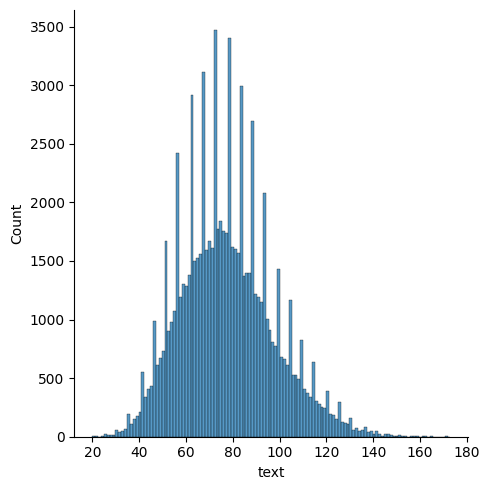

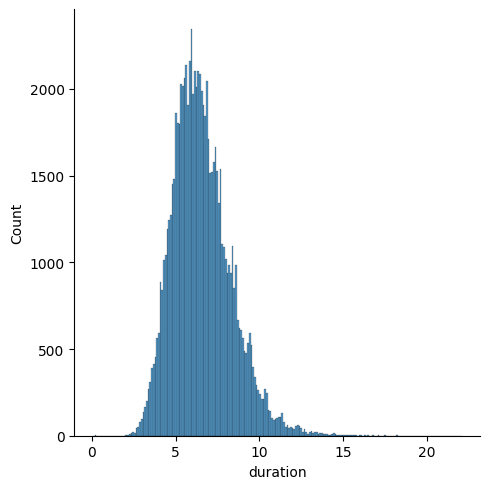

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.displot(data.text.str.len())
plt.show()
sns.displot(data.duration)
plt.show()

In [6]:
np.percentile(data.text.str.len(), 99.5)

135.0

In [7]:
data.text.str.len().max()

173

In [13]:
model

Transformer(
  (vgg): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder): Encoder(
    (emb): Embedding(250, 512)
    (pe): TrainablePositionalEncoding()
    (layers): ModuleList(
      (0): EncoderLayer(
        (attention): MHA(
          (heads): ModuleList(
            (0): MHAHead(
              (v): Sequential(
                (0): Linear(in_features=512, out_features=100, bias=True)
                (1): Linear(in_features=100, out_features=512, bias=True)
              )
      

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = PreTrainedTokenizerFast(tokenizer_file=path_to_tokenizer, padding_side ='right', pad_token ='[PAD]')
dataset = AudioDataset(data, path_to_data, tokenizer, n_fft=1024, n_mels=64, center=True, max_tokenized_length=100, max_audio_len=22, sr=16000)
model = Transformer(vocab_size=len(tokenizer),
                    enc_seq_len=22, dec_seq_len=100,
                    emb_dim=512, 
                 enc_num_layers=2, dec_num_layers=2, 
                 num_heads=3, 
                 ff_dim=128, r_dim=100, 
                 dropout=0.1, 
                 sr=16000, 
                 n_fft=1024)

n_fft=1024, win_lenght=1024, hop_lenght=256, n_mels=64, center=True):

In [9]:
dataset[0]['audio'].shape, dataset[0]['spectre'].shape

(torch.Size([1, 352000]), torch.Size([1, 64, 688]))

In [10]:
dataset[0]['audio'].shape[1]/1024 * 2 + 1

688.5

In [11]:
dataset[0]

{'text': 'по его словам на вчерашний вечер у донбанка просрочек с проведением платежей не было',
 'encoded_text': tensor([[107,  69, 113,  81, 127, 115,  76, 105,  66, 152, 106,  88, 111,  73,
          141, 152,  80,  83, 136,  77, 224,  77, 117, 138,  81, 108, 152,  74,
           81, 138, 141,  68, 184,  76,  79, 124, 121, 167,  73, 118, 157, 127,
            4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
            4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
            4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
            4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
            4,   4]]),
 'spectre': tensor([[[0.0000, 0.0130, 0.0125,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0183, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0133, 0.0182,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0063, 0.0153,  ..., 0.0000, 0.0000, 0.0000],
          [0.0

In [12]:
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    text_batch, specrogram_batch = \
            sample_batched['encoded_text'], sample_batched['spectre']
    batch_size = len(text_batch)
    spec_size = specrogram_batch.shape
    
# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change ``num_workers`` to 0.

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['encoded_text'].size(),
          sample_batched['spectre'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        show_landmarks_batch(sample_batched)
        break

0 torch.Size([4, 1, 100]) torch.Size([4, 1, 64, 688])
1 torch.Size([4, 1, 100]) torch.Size([4, 1, 64, 688])
2 torch.Size([4, 1, 100]) torch.Size([4, 1, 64, 688])
3 torch.Size([4, 1, 100]) torch.Size([4, 1, 64, 688])
